In [6]:
# Import
import pandas as pd
import darts
from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, Prophet
import matplotlib.pyplot as plt
from darts.utils.utils import SeasonalityMode
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, extract_trend_and_seasonality, ModelMode, remove_trend, remove_from_series, stationarity_tests
import glob 
import os
from darts.utils.missing_values import fill_missing_values
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
import sys, os
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import STL

In [7]:
# Merging all files and making the dataframe
# df = pd.concat(map(pd.read_csv, glob.glob(os.path.join("./data" , "*.csv"))), ignore_index= True)
df = pd.read_csv('data/0.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.set_index('timestamp')
df = df.asfreq(freq='T')
df = df.drop(['label'], axis=1)
df = df.resample('H').mean().interpolate()

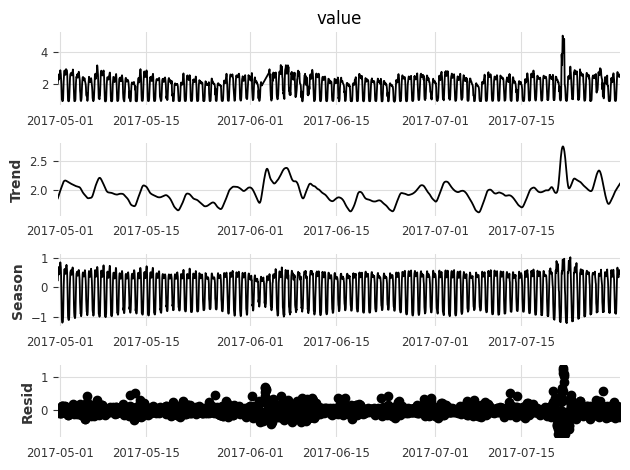

In [8]:
res = STL(df['value']).fit()
res.plot()
plt.show()

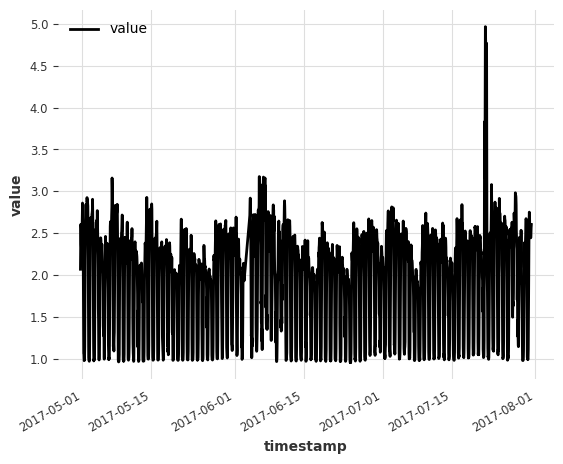

In [9]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, value_cols='value')

# Plot the time series
# plt.rcParams["figure.figsize"] = (20,10)
series.plot()
plt.ylabel("value")
plt.show()

In [10]:
# Check occurence of seasonality and find the period of it
is_sesonal, seasonality_period = check_seasonality(ts = series, m = None, max_lag = 100, alpha = 0.05)
print(is_sesonal)
print(seasonality_period)

True
24


In [11]:
# Decompose trend and sesonality
trend, seasonality = extract_trend_and_seasonality(ts = series, model = ModelMode.ADDITIVE, method = "STL", freq = seasonality_period)
# inja age seosenal nabashe va seasonality_period nadashte bashim bug mikhore
# masalan be ja inke 1000 dade avalo bedim, kol e dade ihro bedim mige seasonality false hast

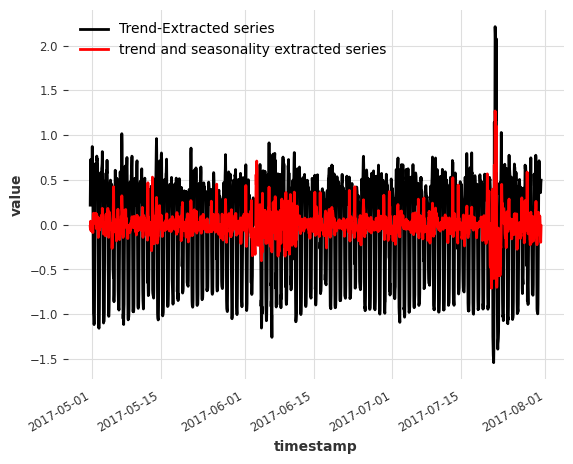

In [12]:
# Extract trend & seasonality
series_minus_trend = remove_from_series(ts = series, other = trend, model = ModelMode.ADDITIVE)
series_minus_trend.plot(label = "Trend-Extracted series")

series_minus_trend_and_sesonality = remove_from_series(ts = series_minus_trend, other = seasonality, model = ModelMode.ADDITIVE )
series_minus_trend_and_sesonality.plot(label = "trend and seasonality extracted series", color = "red")
plt.ylabel("value")
plt.show()

stationary already


/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


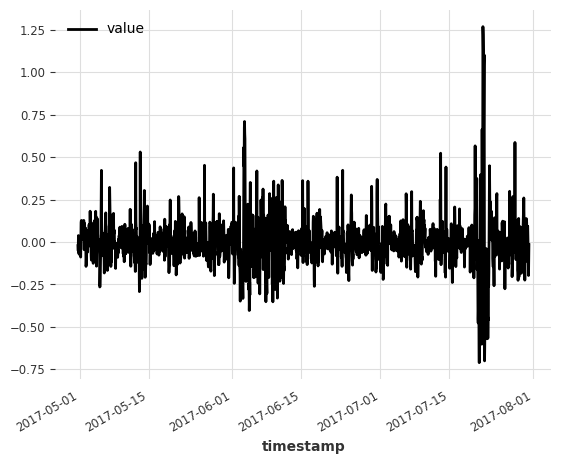

In [13]:
# Checking being stationary or non stationary
is_Stationary = stationarity_tests(ts = series_minus_trend_and_sesonality, p_value_threshold_adfuller = 0.05, p_value_threshold_kpss = 0.05)
if is_Stationary == False:
    # Parameters can be changed to fit better
    series_minus_trend_and_sesonality = series_minus_trend_and_sesonality.diff()
else:
    print("stationary already")
 
final_series = series_minus_trend_and_sesonality.plot()

In [14]:
# Set aside the last 20 percent of ts as a validation series
train, val = series_minus_trend_and_sesonality[:-round(len(df) / 5)], series_minus_trend_and_sesonality[-round(len(df) / 5):]

#### Plotting the timeserie with no trend and sesonality

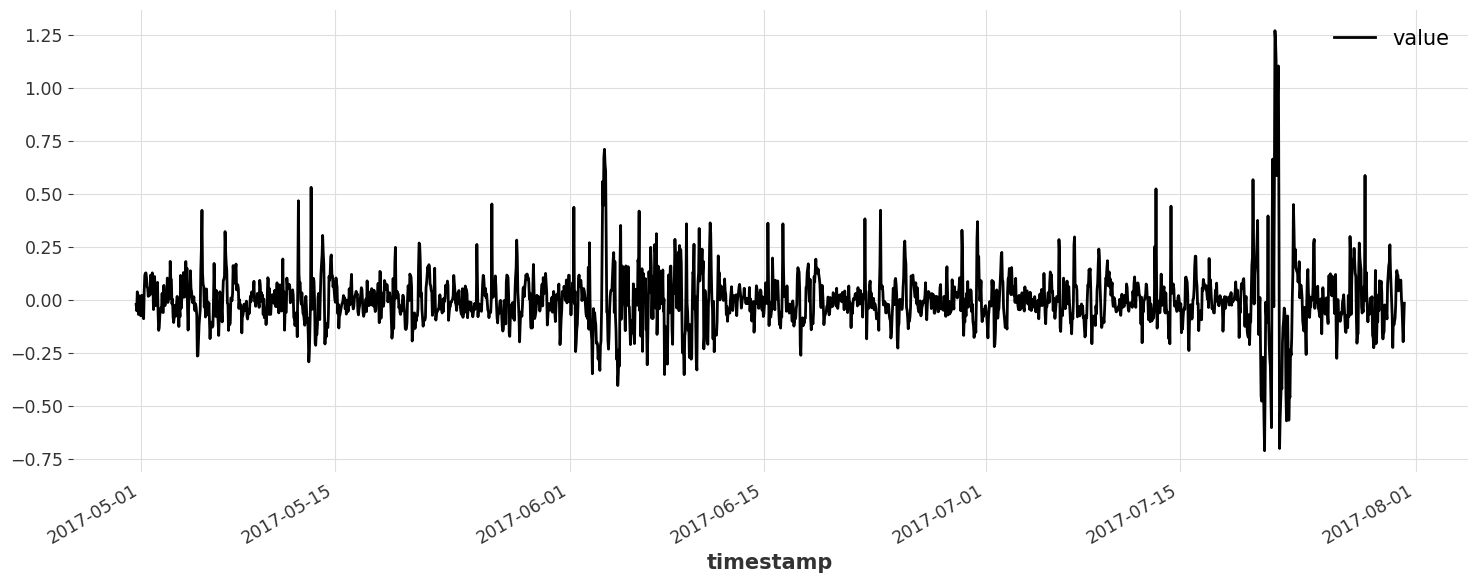

In [15]:
plt.rc('figure',figsize=(18,6))
plt.rc('font',size=15)
series_minus_trend_and_sesonality.plot()

#### Start outlier detection

In [16]:
outliers_fraction = float(.01)
scaler = StandardScaler()
dataframe_style = series_minus_trend_and_sesonality.pd_dataframe() 
np_scaled = scaler.fit_transform(dataframe_style.value.to_numpy().reshape(-1, 1))
data = pd.DataFrame(np_scaled)

#### Train isolation forest

In [17]:
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)
dataframe_style['anomaly'] = model.predict(data)

#### Visualization

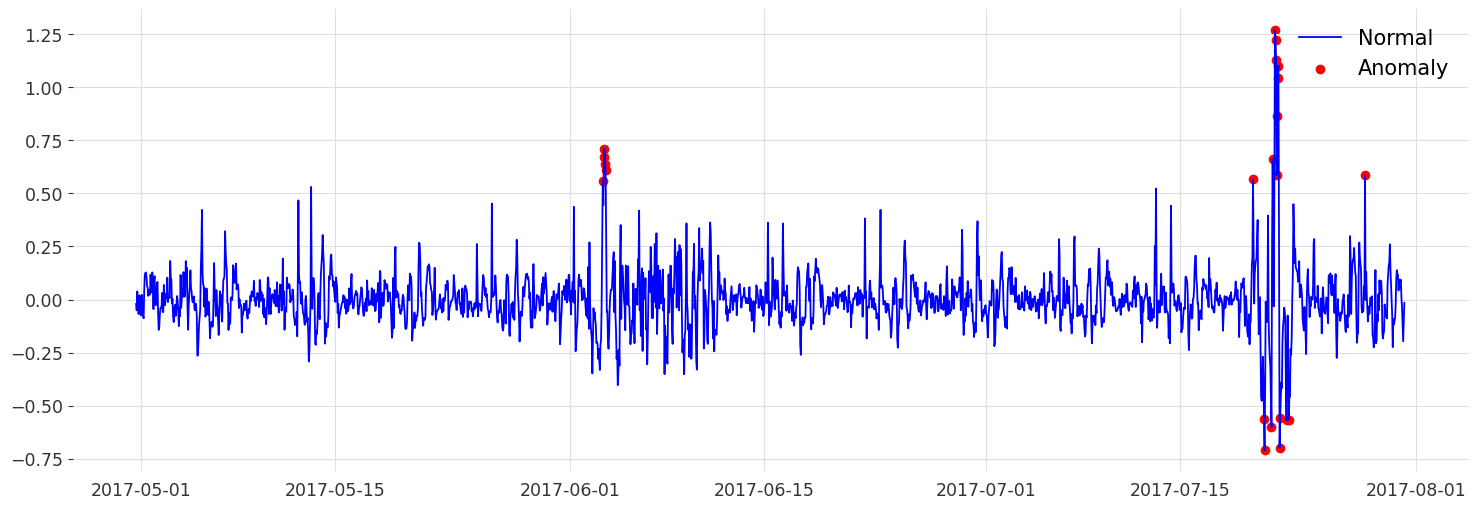

In [18]:
fig, ax = plt.subplots(figsize=(18,6))
a = dataframe_style.loc[dataframe_style['anomaly'] == -1, ['value']] #anomaly
ax.plot(dataframe_style.index, dataframe_style['value'], color='blue', label = 'Normal')
ax.scatter(a.index,a['value'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

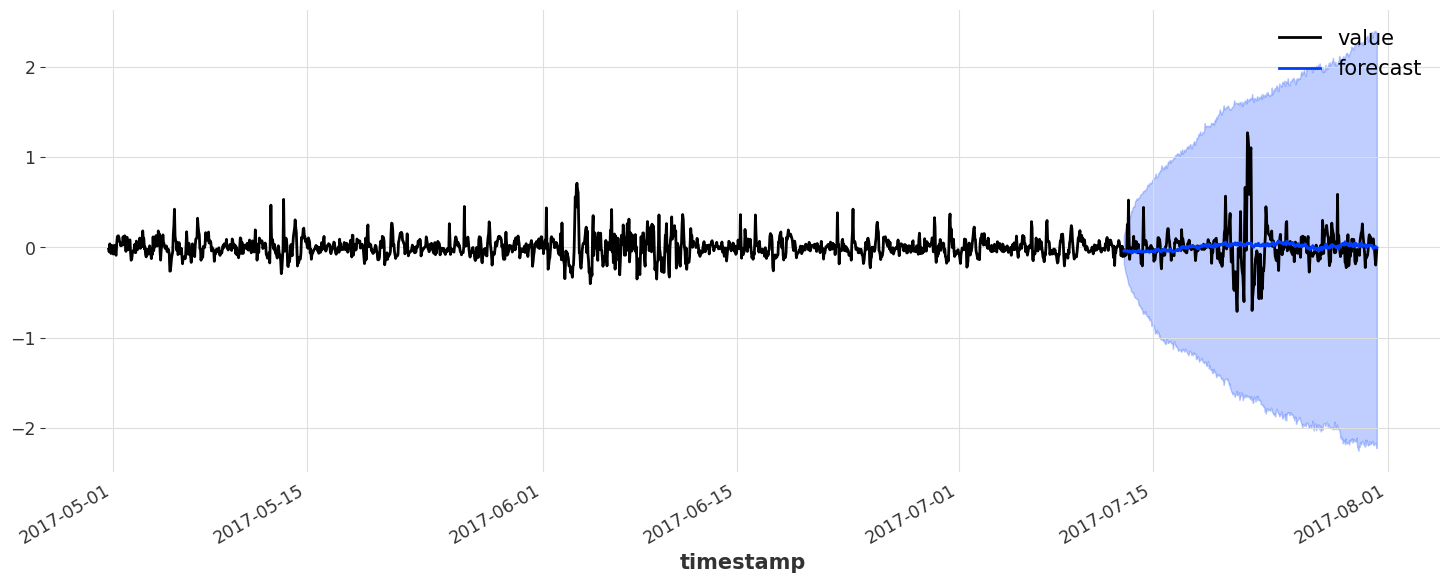

In [19]:
exp_model = ExponentialSmoothing(seasonal_periods=seasonality_period)
exp_model.fit(train)
exp_prediction = exp_model.predict(len(val), num_samples=1000)
# Plotting the predictions
series_minus_trend_and_sesonality.plot()
exp_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


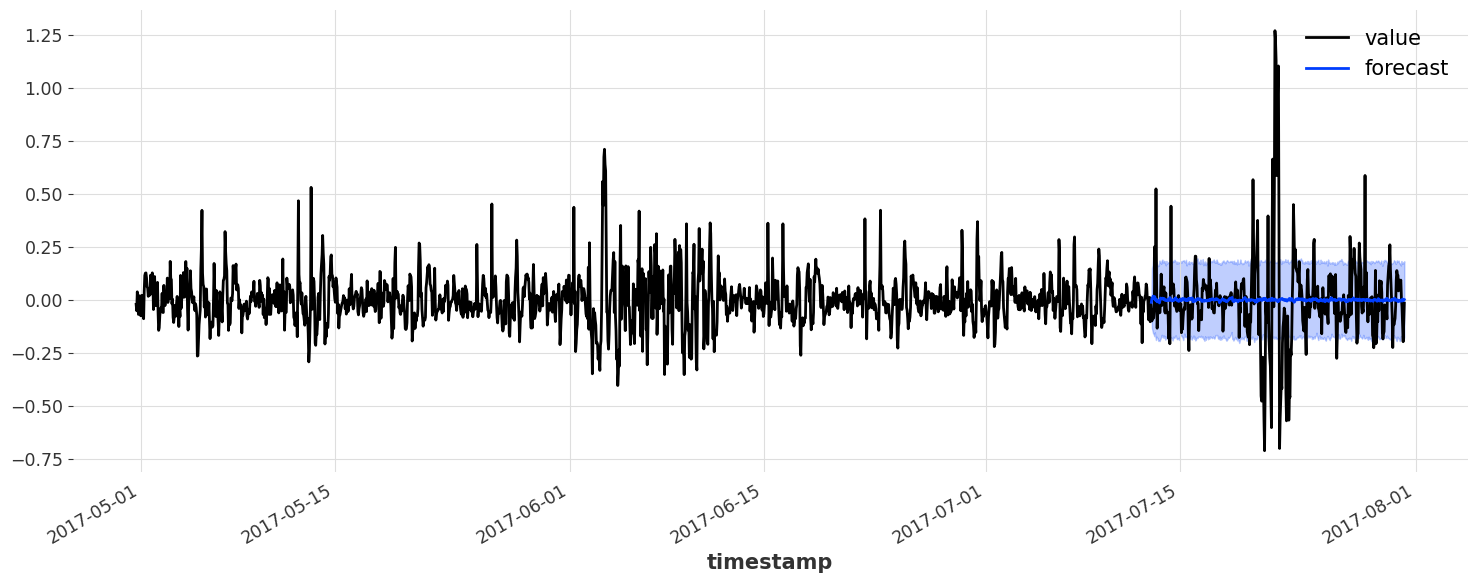

In [20]:
arima_model = ARIMA(9, 1, 5)
arima_model.fit(train)
arima_prediction = arima_model.predict(len(val), num_samples=1000)
# Plotting the predictions
series_minus_trend_and_sesonality.plot()
arima_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

2022-09-07 01:00:08 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-09-07 01:00:08 cmdstanpy DEBUG: input tempfile: /tmp/tmpdqyxapsd/xr31j84l.json
2022-09-07 01:00:08 cmdstanpy DEBUG: input tempfile: /tmp/tmpdqyxapsd/ndzp1sl5.json
2022-09-07 01:00:08 cmdstanpy DEBUG: idx 0
2022-09-07 01:00:08 cmdstanpy DEBUG: running CmdStan, num_threads: None
2022-09-07 01:00:08 cmdstanpy DEBUG: CmdStan args: ['/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56673', 'data', 'file=/tmp/tmpdqyxapsd/xr31j84l.json', 'init=/tmp/tmpdqyxapsd/ndzp1sl5.json', 'output', 'file=/tmp/tmp582ac90b/prophet_model-20220907010008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:00:08 - cmdstanpy - INFO - Chain [1] start processing
2022-09-07 01:00:08 cmdstanpy INFO: Chain [1] start processing
01:00:08 - cmdstanpy - INFO - Chain [1] done processing
2022-09-07 01:00:08 cmdstanpy INFO

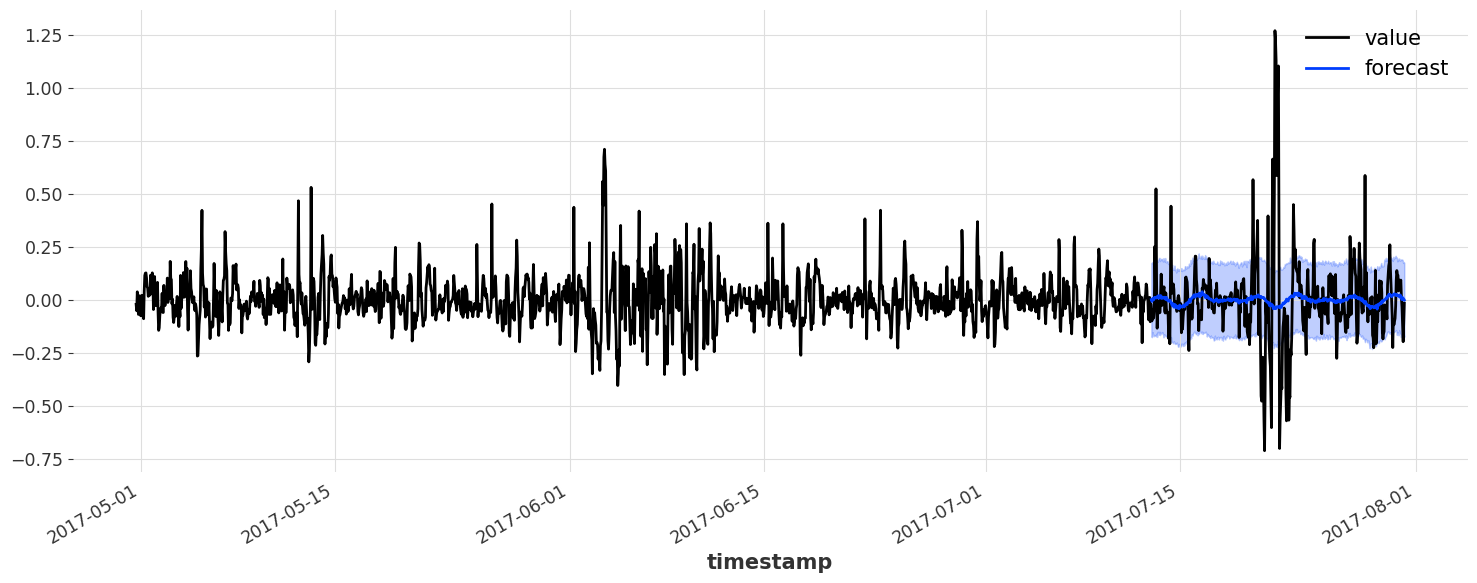

In [21]:
prophet_model = Prophet()
prophet_model.fit(train)
prophet_prediction = prophet_model.predict(len(val), num_samples=1000)
# Plotting the predictions
series_minus_trend_and_sesonality.plot()
prophet_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

#### Metrics - Measure models' performaces

#### Root mean squared error 